In [22]:
import pandas                as     pd
import numpy                 as     np
import scanpy                as     sc
import seaborn               as     sns
import nibabel               as     nib
import matplotlib.pyplot     as     plt 

from scipy.stats             import hypergeom, zscore
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance  import pdist
from plotting                import wedge_plot


def safe_div(x,y):
    if y == 0:
        return np.array([0])
    return x / y


def calculate_enrichment(hit_list, top_genes, full_gene_list):
    x = sum(pd.DataFrame(top_genes).isin(hit_list).values) # how many top genes in cell list
    n = sum(pd.DataFrame(hit_list).isin(full_gene_list).values)[0] # how many cell genes in full list
    N = len(top_genes)  # number of samples
    M = len(full_gene_list)  # total number in population

    enrichment = safe_div( (x/N) , ((n-x) / (M-N)) )
    p = hypergeom.sf(x-1, M, n, N)

    return enrichment, p

def hinton(matrix, pvals, colors, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    assert len(colors) == np.size(matrix)
    ax = ax if ax is not None else plt.gca()
    
    #max_weight = 2 ** np.ceil(np.log2(np.abs(matrix).max()))
    max_weight = 8
    ax.patch.set_facecolor('white')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    n=0
    for (x, y), w in np.ndenumerate(matrix):
        #color = 'white' if w > 0 else 'black'
        color=colors[n]
        size = np.sqrt(abs(w) / max_weight)
        if pvals[x,y] < 0.05:
            rect = plt.Circle([x, y], radius=size/2,
                                 facecolor=color, edgecolor='black',  lw=2)
        else:
            rect = plt.Circle([x, y ], radius=size/2,
                     facecolor=color, edgecolor='white')
        ax.add_patch(rect)
        n+=1
    ax.set_xlim(-.5, matrix.shape[0]-.5)
    ax.set_ylim(-.5, matrix.shape[1]-.5)
    ax.invert_yaxis()

FNT=18

# SCALING MODEL ###############################################################################
scaling_model = 'OLS'

# OTHER OPTIONS ################################################################################
correlation_model = 'kendalltau'

# locations ####################################################################################
microarray_data_path = 'MicroarrayData/'

# location to save outputs
output_dir = 'OUTPUTS/'
results_dir = 'RESULTS/'


# load cluster ids from Bhaduri supplemental materials
marker_genes = pd.read_csv('XXX/BHADURI/Table_S6.csv')
allo_neo = pd.read_csv('XXX/BHADURI/Table_S4.csv')
background = np.loadtxt('RESULTS/all-microarray-genes.txt', dtype=str)

### Load previously calculated data

In [14]:
# load ZRT gene data
gene_identities = pd.read_csv('{:}/ZRT-gene-identities.csv'.format(results_dir))
scaling_genes = gene_identities[gene_identities['is_scaling_reduced']==1]
ZRT_genelist = list(scaling_genes['gene'])

all_microarray_genelist = np.loadtxt('{:}/all-microarray-genes.txt'.format(results_dir), dtype='str')

# load scaling correlation results
results = pd.read_csv('{:}/ZRT-genes-areal-scaling-{:}-{:}.csv'.format(results_dir, scaling_model, correlation_model))

# load microarray data
microarray_data = pd.read_csv('{:}/microarray-data-for-ANOVA.csv'.format(output_dir))


# load single cell data (Bhaduri)
cell_df = pd.read_csv('{:}/scRNA-database.csv'.format(output_dir))
print('final number of cells: {:}'.format(len(cell_df)))


# fix interneuron spelling
spelling_dict = dict(zip(['Inteneuron_combo2_1', 'Inteneuron_combo2_2','Inteneuron_combo2_3', 'Inteneuron_combo2_4', 'Inteneuron_combo2_5', 'Inteneuron_combo2_6', 'Inteneuron_combo2_7', 'Inteneuron_combo2_8','Inteneuron_combo2_9'],
                         ['Interneuron_combo2_1', 'Interneuron_combo2_2', 'Interneuron_combo2_3', 'Interneuron_combo2_4', 'Interneuron_combo2_5', 'Interneuron_combo2_6', 'Interneuron_combo2_7', 'Interneuron_combo2_8', 'Interneuron_combo2_9']))
for i in spelling_dict.keys():
    marker_genes.loc[marker_genes['cluster'] == i,'cluster'] = spelling_dict[i]
    

# get areal scaling data
scaling_roi = '{:}/cortical-corr-area-parcellated-scaling-{:}.csv'.format(results_dir, scaling_model)
scaling = pd.read_csv(scaling_roi)
scaling_dict = dict(zip(scaling['name'], scaling['scaling_median']))

# drop allocortex
drop_zones = ['entorhinal',
              'hippocampus',
              'paleocortex',
              'retrosplenial']



final number of cells: 349015


### Cortical type specificity of ZRT scaling genes

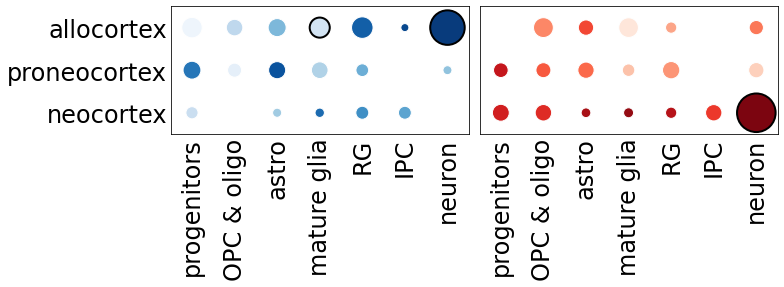

In [25]:
# enrichment of ZRT_scaling genes in cell subtypes in allo- and neocortex

# zrt scaling
negative_scaling = results[(results['r']<0) & (results['fdrp']<0.01)]['gene'].unique()
positive_scaling = results[(results['r']>0) & (results['fdrp']<0.01)]['gene'].unique()

output_df = []
# calculate enrichment of region-specific cell signatures for positive and negative ZRT genes
for l,n in zip([positive_scaling, negative_scaling], ['positive', 'negative']):
    cell_list = []
    cell_enrichment = []
    cell_p = []
    for cell_type in allo_neo['cell_type'].unique():
        type_enrichment = []
        type_p = []
        for clus in allo_neo['cluster'].unique():
            g_list = allo_neo[(allo_neo['cell_type']==cell_type) & (allo_neo['cluster']==clus)]
            if len(g_list)>0:
                e,p = calculate_enrichment(list(g_list['gene']), list(l), background)
                type_enrichment.append(e[0])
                type_p.append(p[0])
            else:
                type_enrichment.append(0)
                type_p.append(1)
        cell_list.append(cell_type)
        cell_enrichment.append(type_enrichment)
        cell_p.append(type_p)
    p_df = pd.DataFrame(cell_p, columns = allo_neo['cluster'].unique())
    p_df.insert(0, 'values', 'p')
    p_df.insert(0, 'list', n)
    p_df.index = cell_list
    
    en_df = pd.DataFrame(cell_enrichment, columns = allo_neo['cluster'].unique())
    en_df.insert(0, 'values', 'enrichment')
    en_df.insert(0, 'list', n)
    en_df.index = cell_list

    
    output_df.append(pd.concat((en_df, p_df)))
    
output_df = pd.concat(output_df)
output_df.to_csv('RESULTS/allocortex-neocortex-signatures-zrt-scaling-kendalltau-OLS.csv')


fig, ax = plt.subplots(1,2, figsize = (11,8), sharey=True)

order = ['progenitors', 'OPC/oligo', 'Astrocyte', 'mature glia', 'radial glia', 'IPC', 'Neuron']

positive_data = output_df[(output_df['list']=='positive') & (output_df['values']=='enrichment')][['allocortex', 'proneocortex', 'neocortex']]
positive_data = positive_data.loc[order]
positive_p = output_df[(output_df['list']=='positive') & (output_df['values']=='p')][['allocortex', 'proneocortex', 'neocortex']]
positive_p = positive_p.loc[order]

negative_data = output_df[(output_df['list']=='negative') & (output_df['values']=='enrichment')][['allocortex', 'proneocortex', 'neocortex']]
negative_data = negative_data.loc[order]
negative_p = output_df[(output_df['list']=='negative') & (output_df['values']=='p')][['allocortex', 'proneocortex', 'neocortex']]
negative_p = negative_p.loc[order]

pos_colors = np.array(sns.color_palette('Reds', n_colors=21))
pos_colors = pos_colors[np.argsort(positive_data.values.flatten(order='C'))]

neg_colors = np.array(sns.color_palette('Blues_r', n_colors=21))
neg_colors = neg_colors[np.argsort(negative_data.values.flatten(order='C'))]

hinton(positive_data.values, positive_p.values, pos_colors, ax=ax[1])
hinton(negative_data.values, negative_p.values, neg_colors, ax=ax[0])

ax[0].set_yticks([0,1,2], labels=negative_data.columns, fontsize=24)
for a in ax:
    a.set_xticks(np.arange(7), labels=['progenitors', 'OPC & oligo', 'astro', 'mature glia', 'RG', 'IPC', 'neuron'],
                 fontsize=24, rotation=90)
    a.tick_params('both', length=0)
plt.tight_layout()
plt.savefig('RESULTS/allocortex-neocortex-signatures-enrichment.png', dpi=300, transparent=False, facecolor='white')

### Plot positive and negatively ZRT_neo genes in each tissue at each timepoint
Examine (normalised) gene expression for each significant neocortical scaling relationship across tissue and timepoints

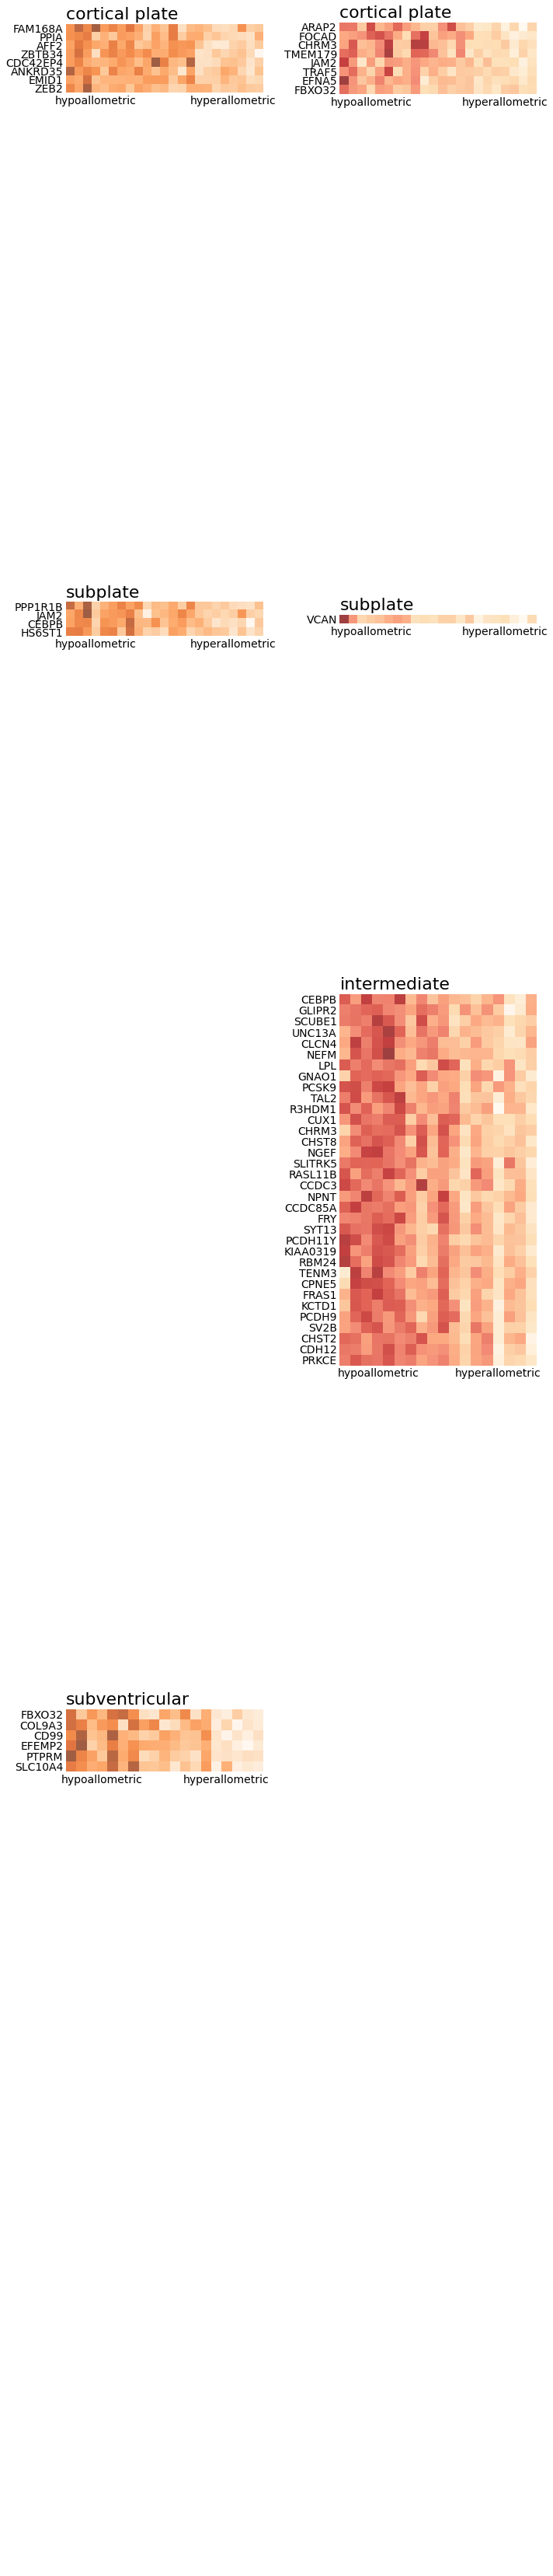

In [26]:
fig, ax = plt.subplots(5,2, figsize=(10,50))

## POSITIVE SCALING GENES
# significant scaling genes (in neocortex)
significant_scaling_pos = results[(results['scaling-reduced']) & (results['r-reduced']>0)]

# @ early timepoint
early_significant_scaling_pos = significant_scaling_pos[significant_scaling_pos['timepoint']=='early']

# @ mid timepoint
mid_significant_scaling_pos = significant_scaling_pos[significant_scaling_pos['timepoint']=='mid']

# for each tissue
early_tissue_dfs_pos = []
mid_tissue_dfs_pos = []
for tissue in ['0.cortical_plate', '1.subplate', '2.intermediate', '3.subventricular', '4.ventricular']:
    early_tissue_dfs_pos.append(early_significant_scaling_pos[early_significant_scaling_pos['tissue']==tissue])
    mid_tissue_dfs_pos.append(mid_significant_scaling_pos[mid_significant_scaling_pos['tissue']==tissue])

tissue_list = ['cortical plate', 'subplate', 'intermediate', 'subventricular', 'ventricular']

## EARLY TIMEPOINT
for n, m in enumerate(early_tissue_dfs_pos):
    all_ma_data = []
    for i in m.index:
        gene = m.loc[i]['gene']
        tissue = m.loc[i]['tissue']
        # get microarray data for all regions for a given scaling gene
        ma_data = microarray_data[(microarray_data['gene']==gene) &
                                  (microarray_data['timepoint']=='early') &
                                  (microarray_data['tissue']==tissue)]
        ma_data = ma_data.groupby(by='cortical_region').mean().reset_index()
        # z-score across regions
        ma_data['norm_expression'] = zscore(ma_data['expression'])
        ma_data = ma_data.drop(['DS', 'expression'], axis='columns')
        ma_data = ma_data[~ma_data['cortical_region'].isin(drop_zones)]
        ma_data['gene'] = gene

        all_ma_data.append(ma_data)
    
    if len(all_ma_data) == 0:
        ax[n][0].tick_params('both', length=0)
        ax[n][0].set_xticklabels('')
        ax[n][0].set_yticklabels('')

        continue
        
    else:

        all_ma_data = pd.concat(all_ma_data)
        all_ma_data = all_ma_data.pivot_table(index='gene', columns='cortical_region', values='norm_expression')
        # sort by scaling
        all_ma_data = all_ma_data.iloc[:,np.argsort(all_ma_data.columns.map(scaling_dict))]


        # plot, cluster genes by similarity
        if len(all_ma_data)>1:
            l = leaves_list(linkage(np.nan_to_num(pdist(all_ma_data), nan=np.nanmean(pdist(all_ma_data)))))
            ax[n][0].matshow(all_ma_data.iloc[l,:], aspect=1, cmap='Oranges_r', alpha=0.75)
            ax[n][0].set_yticks(np.arange(len(all_ma_data)), all_ma_data.iloc[l,:].index)
            ax[n][0].tick_params('both', length=0, labelsize=FNT-4)
            ax[n][0].set_title(tissue_list[n], fontsize=FNT+4, loc='left')
            ax[n][0].set_xticks([3, np.shape(all_ma_data)[1]-4], ['hypoallometric','hyperallometric'])
            ax[n][0].xaxis.tick_bottom()

        else:
            ax[n][0].matshow(all_ma_data, aspect=1, cmap='Oranges_r', alpha=0.75)
            ax[n][0].set_yticks(np.arange(len(all_ma_data)), all_ma_data.index)
            ax[n][0].tick_params('both', length=0, labelsize=FNT-4)
            ax[n][0].set_title(tissue_list[n], fontsize=FNT+4, loc='left')
            ax[n][0].set_xticks([3, np.shape(all_ma_data)[1]-4], ['hypoallometric','hyperallometric'])
            ax[n][0].xaxis.tick_bottom()
            
## MID TIMEPOINT           
for n, m in enumerate(mid_tissue_dfs_pos):
    all_ma_data = []
    for i in m.index:
        gene = m.loc[i]['gene']
        tissue = m.loc[i]['tissue']
        ma_data = microarray_data[(microarray_data['gene']==gene) &
                                  (microarray_data['timepoint']=='mid') &
                                  (microarray_data['tissue']==tissue)]
        ma_data = ma_data.groupby(by='cortical_region').mean().reset_index()
        ma_data['norm_expression'] = zscore(ma_data['expression'])
        ma_data = ma_data.drop(['DS', 'expression'], axis='columns')
        ma_data = ma_data[~ma_data['cortical_region'].isin(drop_zones)]
        ma_data['gene'] = gene

        all_ma_data.append(ma_data)
    
    if len(all_ma_data) == 0:
        ax[n][1].tick_params('both', length=0)
        ax[n][1].set_xticklabels('')
        ax[n][1].set_yticklabels('')

        continue
        
    else:

        all_ma_data = pd.concat(all_ma_data)
        all_ma_data = all_ma_data.pivot_table(index='gene', columns='cortical_region', values='norm_expression')
        # sort by scaling
        all_ma_data = all_ma_data.iloc[:,np.argsort(all_ma_data.columns.map(scaling_dict))]


        # gene order
        if len(all_ma_data)>1:
            l = leaves_list(linkage(np.nan_to_num(pdist(all_ma_data), nan=np.nanmean(pdist(all_ma_data)))))
            ax[n][1].matshow(all_ma_data.iloc[l,:], aspect=1, cmap='OrRd_r', alpha=0.75)
            ax[n][1].set_yticks(np.arange(len(all_ma_data)), all_ma_data.iloc[l,:].index)
            ax[n][1].tick_params('both', length=0, labelsize=FNT-4)
            ax[n][1].set_title(tissue_list[n], fontsize=FNT+4, loc='left')
            ax[n][1].set_xticks([3, np.shape(all_ma_data)[1]-4], ['hypoallometric','hyperallometric'])
            ax[n][1].xaxis.tick_bottom()

        else:
            ax[n][1].matshow(all_ma_data, aspect=1, cmap='OrRd_r', alpha=0.75)
            ax[n][1].set_yticks(np.arange(len(all_ma_data)), all_ma_data.index)
            ax[n][1].tick_params('both', length=0, labelsize=FNT-4)
            ax[n][1].set_title(tissue_list[n], fontsize=FNT+4, loc='left')
            ax[n][1].set_xticks([3, np.shape(all_ma_data)[1]-4], ['hypoallometric','hyperallometric'])
            ax[n][1].xaxis.tick_bottom()

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('{:}/positive-scaling-genes-reduced-by-tissue-{:}-{:}.png'.format(results_dir, scaling_model, correlation_model), dpi=300, transparent=False, facecolor='white')

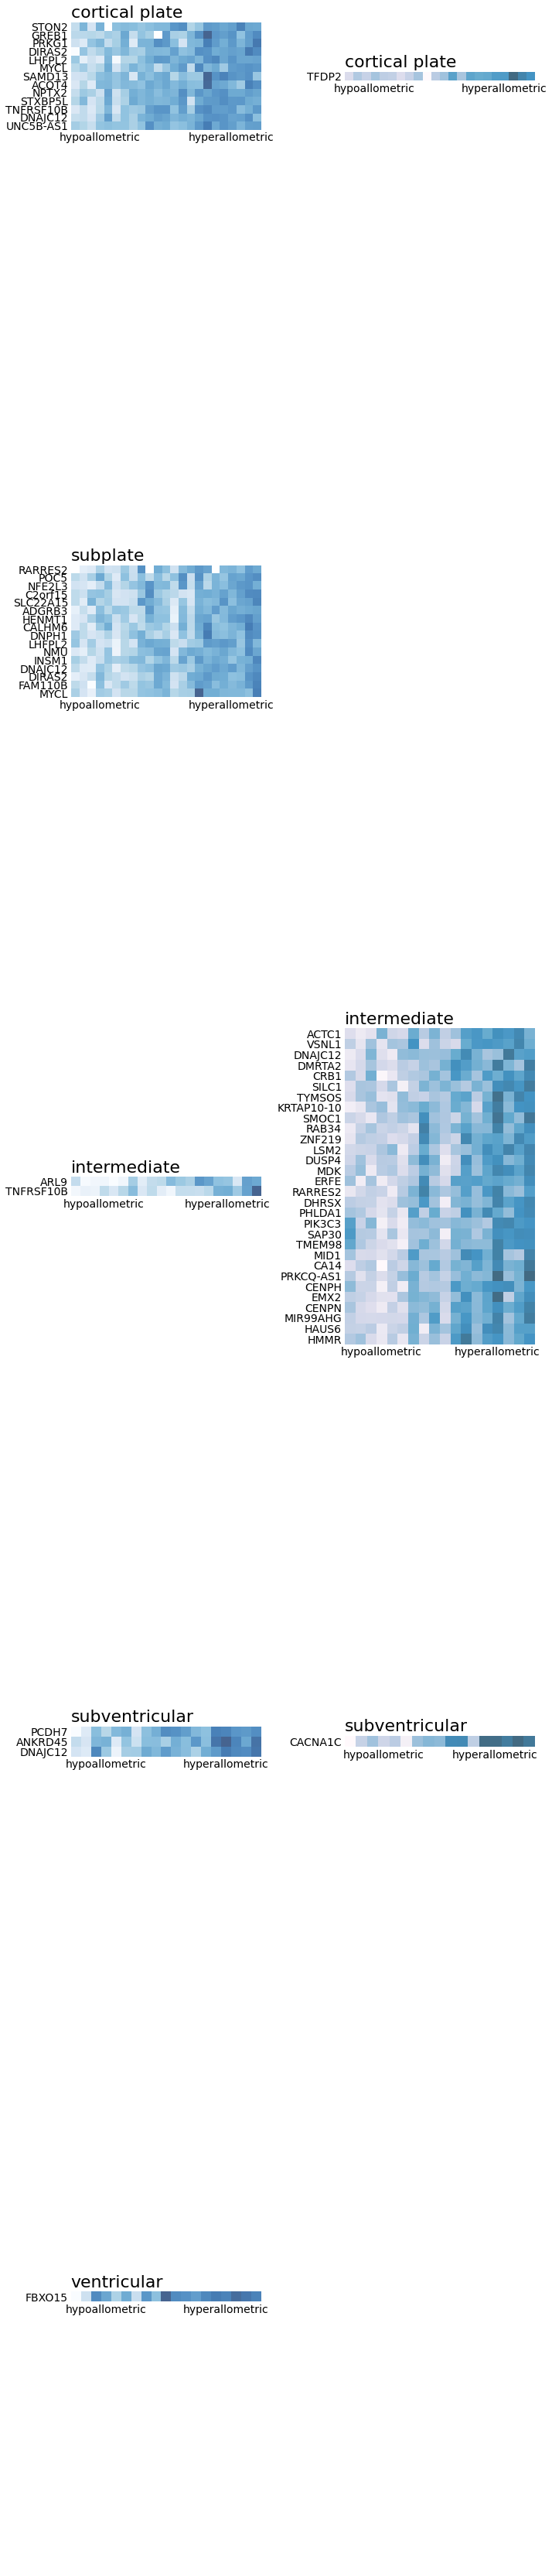

In [27]:
fig, ax = plt.subplots(5,2, figsize=(10,50))

## NEGATIVE SCALING GENES
# significant scaling genes
significant_scaling_neg = results[(results['scaling-reduced']) & (results['r-reduced']<0)]

# @ early timepoint
early_significant_scaling_neg = significant_scaling_neg[significant_scaling_neg['timepoint']=='early']

# @ mid timepoint
mid_significant_scaling_neg = significant_scaling_neg[significant_scaling_neg['timepoint']=='mid']

# for each tissue
early_tissue_dfs_neg = []
mid_tissue_dfs_neg = []
for tissue in ['0.cortical_plate', '1.subplate', '2.intermediate', '3.subventricular', '4.ventricular']:
    early_tissue_dfs_neg.append(early_significant_scaling_neg[early_significant_scaling_neg['tissue']==tissue])
    mid_tissue_dfs_neg.append(mid_significant_scaling_neg[mid_significant_scaling_neg['tissue']==tissue])

tissue_list = ['cortical plate', 'subplate', 'intermediate', 'subventricular', 'ventricular']

## EARLY TIMEPOINT
for n, m in enumerate(early_tissue_dfs_neg):
    all_ma_data = []
    for i in m.index:
        gene = m.loc[i]['gene']
        tissue = m.loc[i]['tissue']
        ma_data = microarray_data[(microarray_data['gene']==gene) &
                                  (microarray_data['timepoint']=='early') &
                                  (microarray_data['tissue']==tissue)]
        ma_data = ma_data.groupby(by='cortical_region').mean().reset_index()
        ma_data['norm_expression'] = zscore(ma_data['expression'])
        ma_data = ma_data.drop(['DS', 'expression'], axis='columns')
        ma_data = ma_data[~ma_data['cortical_region'].isin(drop_zones)]
        ma_data['gene'] = gene

        all_ma_data.append(ma_data)
    
    if len(all_ma_data) == 0:
        ax[n][0].tick_params('both', length=0)
        ax[n][0].set_xticklabels('')
        ax[n][0].set_yticklabels('')

        continue
        
    else:

        all_ma_data = pd.concat(all_ma_data)
        all_ma_data = all_ma_data.pivot_table(index='gene', columns='cortical_region', values='norm_expression')
        # sort by scaling
        all_ma_data = all_ma_data.iloc[:,np.argsort(all_ma_data.columns.map(scaling_dict))]


        # gene order
        if len(all_ma_data)>1:
            l = leaves_list(linkage(np.nan_to_num(pdist(all_ma_data), nan=np.nanmean(pdist(all_ma_data)))))
            ax[n][0].matshow(all_ma_data.iloc[l,:], aspect=1, cmap='Blues_r', alpha=0.75)
            ax[n][0].set_yticks(np.arange(len(all_ma_data)), all_ma_data.iloc[l,:].index)
            ax[n][0].tick_params('both', length=0, labelsize=FNT-4)
            ax[n][0].set_title(tissue_list[n], fontsize=FNT+4, loc='left')
            ax[n][0].set_xticks([3, np.shape(all_ma_data)[1]-4], ['hypoallometric','hyperallometric'])
            ax[n][0].xaxis.tick_bottom()

        else:
            ax[n][0].matshow(all_ma_data, aspect=1, cmap='Blues_r', alpha=0.75)
            ax[n][0].set_yticks(np.arange(len(all_ma_data)), all_ma_data.index)
            ax[n][0].tick_params('both', length=0, labelsize=FNT-4)
            ax[n][0].set_xticklabels('')
            ax[n][0].set_title(tissue_list[n], fontsize=FNT+4, loc='left')
            ax[n][0].set_xticks([3, np.shape(all_ma_data)[1]-4], ['hypoallometric','hyperallometric'])
            ax[n][0].xaxis.tick_bottom()
            
## MID TIMEPOINT           
for n, m in enumerate(mid_tissue_dfs_neg):
    all_ma_data = []
    for i in m.index:
        gene = m.loc[i]['gene']
        tissue = m.loc[i]['tissue']
        ma_data = microarray_data[(microarray_data['gene']==gene) &
                                  (microarray_data['timepoint']=='mid') &
                                  (microarray_data['tissue']==tissue)]
        ma_data = ma_data.groupby(by='cortical_region').mean().reset_index()
        ma_data['norm_expression'] = zscore(ma_data['expression'])
        ma_data = ma_data.drop(['DS', 'expression'], axis='columns')
        ma_data = ma_data[~ma_data['cortical_region'].isin(drop_zones)]
        ma_data['gene'] = gene

        all_ma_data.append(ma_data)
    
    if len(all_ma_data) == 0:
        ax[n][1].tick_params('both', length=0)
        ax[n][1].set_xticklabels('')
        ax[n][1].set_yticklabels('')

        continue
        
    else:

        all_ma_data = pd.concat(all_ma_data)
        all_ma_data = all_ma_data.pivot_table(index='gene', columns='cortical_region', values='norm_expression')
        # sort by scaling
        all_ma_data = all_ma_data.iloc[:,np.argsort(all_ma_data.columns.map(scaling_dict))]


        # gene order
        if len(all_ma_data)>1:
            l = leaves_list(linkage(np.nan_to_num(pdist(all_ma_data), nan=np.nanmean(pdist(all_ma_data)))))
            ax[n][1].matshow(all_ma_data.iloc[l,:], aspect=1, cmap='PuBu_r', alpha=0.75)
            ax[n][1].set_yticks(np.arange(len(all_ma_data)), all_ma_data.iloc[l,:].index)
            ax[n][1].tick_params('both', length=0, labelsize=FNT-4)
            ax[n][1].set_title(tissue_list[n], fontsize=FNT+4, loc='left')
            ax[n][1].set_xticks([3, np.shape(all_ma_data)[1]-4], ['hypoallometric','hyperallometric'])
            ax[n][1].xaxis.tick_bottom()

        else:
            ax[n][1].matshow(all_ma_data, aspect=1, cmap='PuBu_r', alpha=0.75)
            ax[n][1].set_yticks(np.arange(len(all_ma_data)), all_ma_data.index)
            ax[n][1].tick_params('both', length=0, labelsize=FNT-4)
            ax[n][1].set_title(tissue_list[n], fontsize=FNT+4, loc='left')
            ax[n][1].set_xticks([3, np.shape(all_ma_data)[1]-4], ['hypoallometric','hyperallometric'])
            ax[n][1].xaxis.tick_bottom()
            
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('{:}/negative-scaling-genes-reduced-by-tissue-{:}-{:}.png'.format(results_dir, scaling_model, correlation_model), dpi=300, transparent=False, facecolor='white')

In [28]:
# gather marker gene lists ####################################################################################
# gene markers for each cluster
all_clus = []
all_markers = []
# for each cluster collate DE gene lists
for clus in cell_df['cluster'].unique():
    all_clus.append(clus)
    all_markers.append(marker_genes[marker_genes['cluster'] == clus]['gene'].values)

cluster_markers = pd.DataFrame((all_clus, all_markers)).T
cluster_markers.columns = ['cluster', 'markers']


# gather clusters into cell types
cluster_to_type = dict(zip(cell_df['cluster'], cell_df['cluster_type']))
cluster_markers['type'] = cluster_markers['cluster'].map(cluster_to_type)

# all gene markers for all clusters in each cell type
all_types = []
all_markers = []
for t in cluster_markers['type'].unique():
    all_types.append(t)
    marker_list = list(np.unique(np.concatenate(cluster_markers[cluster_markers['type']==t]['markers'].values)))
    # remove dates!
    marker_list = [mm for mm in marker_list if ('Sep' not in mm) and ('Mar' not in mm)]
    all_markers.append(marker_list)

type_markers = pd.DataFrame((all_types, all_markers)).T
type_markers.columns = ['type', 'markers']


# CELL TYPE ENRICHMENT #####################################################################################################
# calculate cell type enrichment for scaling genes
# get list of genes positively or negatively) correlated with neocortical scaling at each time point across all tissues
early_negative = list(pd.concat(early_tissue_dfs_neg)['gene'].unique())
early_positive = list(pd.concat(early_tissue_dfs_pos)['gene'].unique())
mid_negative = list(pd.concat(mid_tissue_dfs_neg)['gene'].unique())
mid_positive = list(pd.concat(mid_tissue_dfs_pos)['gene'].unique())

# for each gene list calculate enrichment compared to all microarray genes in each cell type
all_enrichments = []
for gene_lists in [early_negative, early_positive, mid_negative, mid_positive]:
    cells = []
    enrichment = []
    ps = []
    for cell in type_markers['type']:
        cells.append(cell)
        if len(type_markers[type_markers['type']==cell]['markers'].tolist()[0]) > 0:
            e,p = calculate_enrichment(type_markers[type_markers['type']==cell]['markers'].tolist()[0], gene_lists, all_microarray_genelist)
            enrichment.append(e[0])
            ps.append(p[0])
        else:
            enrichment.append(np.nan)
            ps.append(np.nan)

    cell_type_enrichment = pd.DataFrame((cells, enrichment, ps)).T
    cell_type_enrichment.columns = ['cell type', 'enrichment ratio', 'p']
    all_enrichments.append(cell_type_enrichment)
    
all_enrichments[0].to_csv('{:}/early-negative-scaling-gene-reduced-cell-enrichments-{:}-{:}.csv'.format(results_dir, scaling_model, correlation_model), index=None)
all_enrichments[1].to_csv('{:}/early-positive-scaling-gene-reduced-cell-enrichments-{:}-{:}.csv'.format(results_dir, scaling_model, correlation_model), index=None)
all_enrichments[2].to_csv('{:}/mid-negative-scaling-gene-reduced-cell-enrichments-{:}-{:}.csv'.format(results_dir, scaling_model, correlation_model), index=None)
all_enrichments[3].to_csv('{:}/mid-positive-scaling-gene-reduced-cell-enrichments-{:}-{:}.csv'.format(results_dir, scaling_model, correlation_model), index=None)

repeat above but for individual cell clusters

In [29]:
# calculate cluster enrichment for ZRT_neo genes
# repeat for individual cell clusters
all_cell_enrichments = []
for gene_lists in [early_negative, early_positive, mid_negative, mid_positive]:

    cells = []
    enrichment = []
    ps = []
    for cell in cluster_markers['cluster']:
        cells.append(cell)
        if len(cluster_markers[cluster_markers['cluster']==cell]['markers'].tolist()[0]) > 0:
            e,p = calculate_enrichment(cluster_markers[cluster_markers['cluster']==cell]['markers'].tolist()[0], gene_lists, all_microarray_genelist)
            enrichment.append(e[0])
            ps.append(p[0])
        else:
            enrichment.append(np.nan)
            ps.append(np.nan)

    cell_cluster_enrichment = pd.DataFrame((cells, enrichment, ps)).T
    cell_cluster_enrichment.columns = ['cell cluster', 'enrichment ratio', 'p']
    cell_cluster_enrichment['cell type'] = cell_cluster_enrichment['cell cluster'].map(cluster_to_type)

    all_cell_enrichments.append(cell_cluster_enrichment)
    


plot on UMAP embedding


see RESULTS//negative-scaling-genes-reduced-early-UMAP-cell-type-enrichment-OLS-kendalltau.png

see RESULTS//positive-scaling-genes-reduced-early-UMAP-cell-type-enrichment-OLS-kendalltau.png

see RESULTS//negative-scaling-genes-reduced-mid-UMAP-cell-type-enrichment-OLS-kendalltau.png

see RESULTS//positive-scaling-genes-reduced-mid-UMAP-cell-type-enrichment-OLS-kendalltau.png


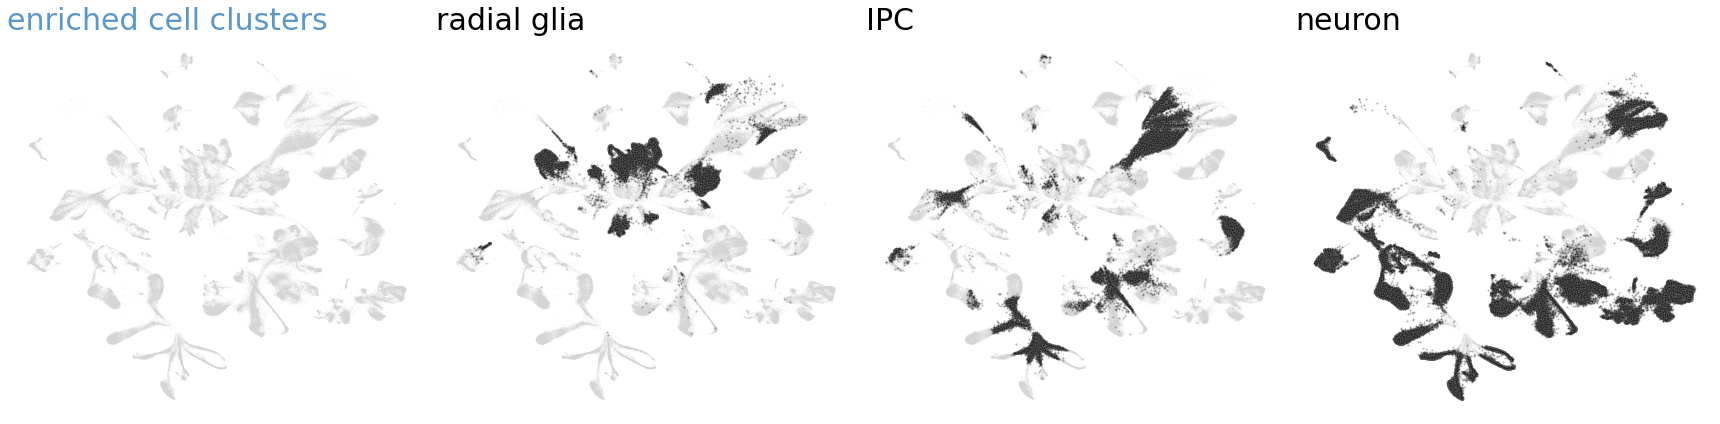

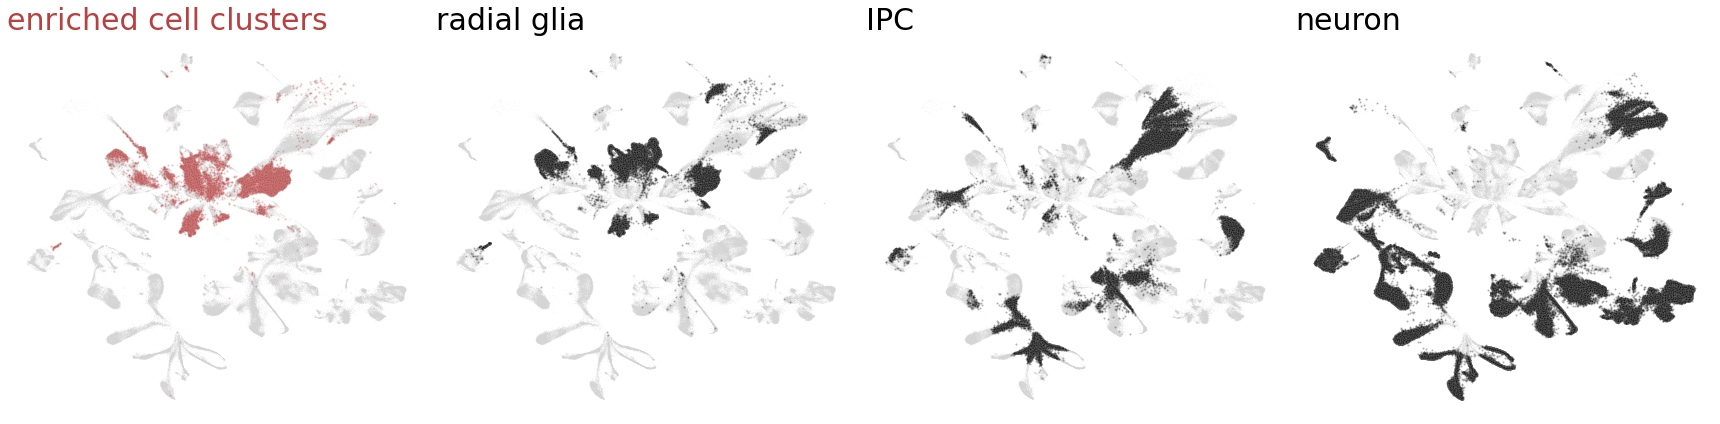

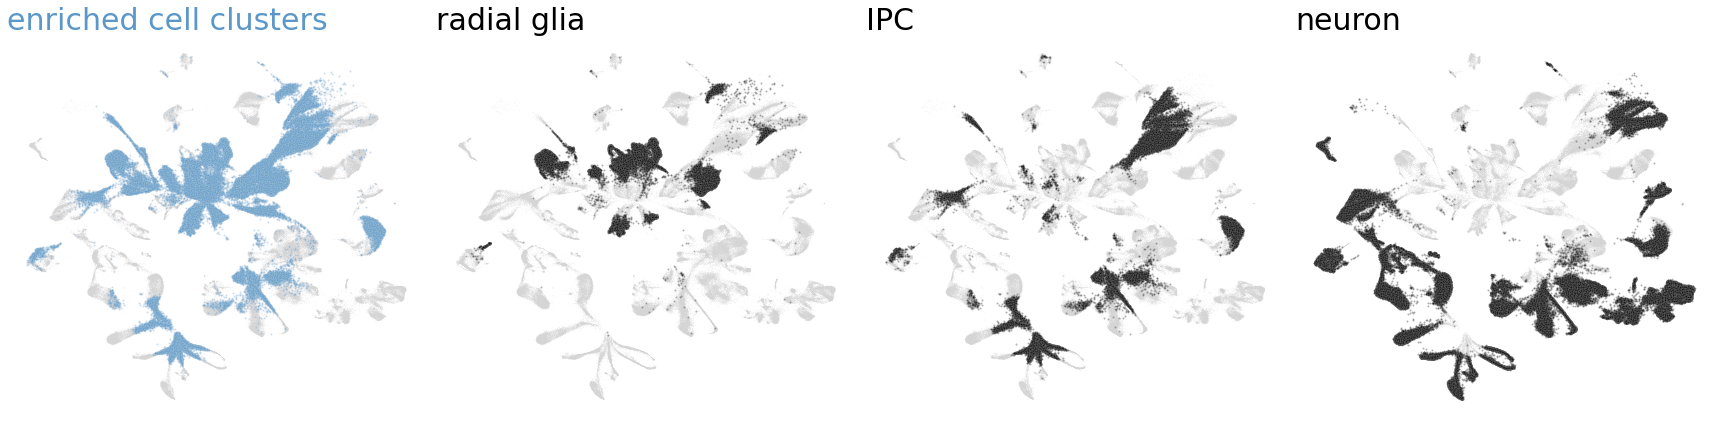

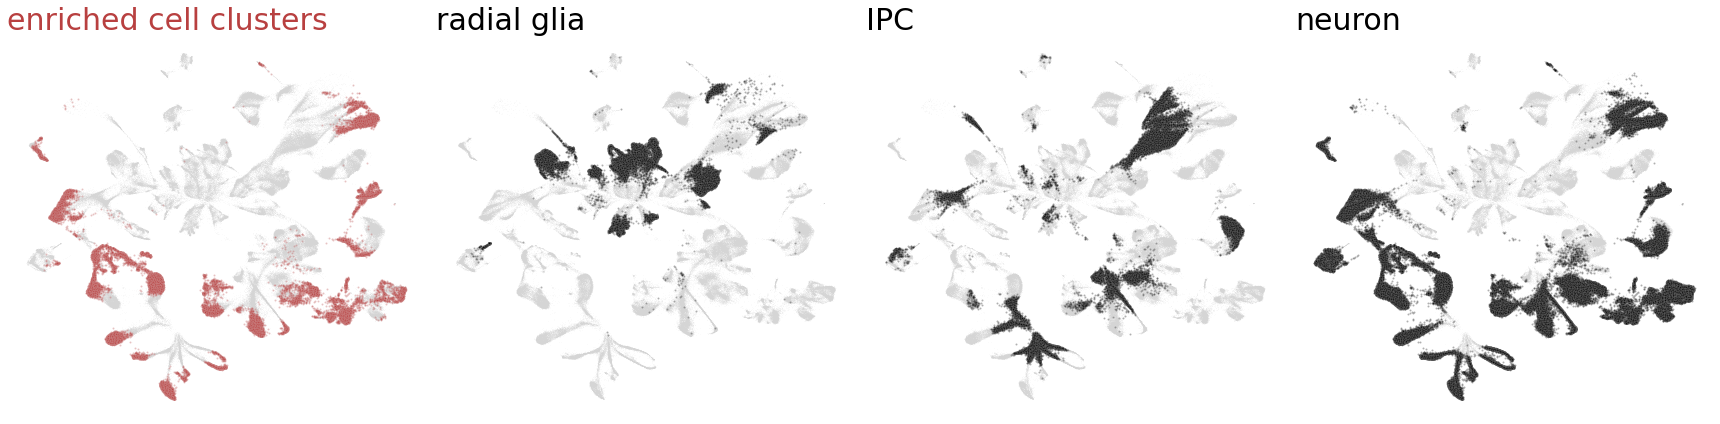

In [30]:
# umap plots showing ditribution of significant clustetrs
for n, (timing, direction, enrichment) in enumerate(zip(['early', 'early','mid','mid'], ['negative','positive', 'negative', 'positive'], all_cell_enrichments)):

    cluster_enrichment_dict = dict(zip(enrichment['cell cluster'], enrichment['enrichment ratio']))
    cell_df['enrichment'] = cell_df['cluster'].map(cluster_enrichment_dict)
    cluster_p_dict = dict(zip(enrichment['cell cluster'], enrichment['p']))
    cell_df['enrichment p'] = cell_df['cluster'].map(cluster_p_dict)

    fig, ax = plt.subplots(1,4, figsize=(24, 6))
    ax = ax.reshape(-1)

    # UMAPS
    for a in ax:
        sns.scatterplot(x='umap1', y='umap2', 
                    s=1, alpha=0.1, legend=False, 
                    data=cell_df, color='lightgrey', ax=a)

    # significant clusters
    if direction=='negative':
        sns.scatterplot(x='umap1', y='umap2', 
                    s=4, alpha=0.3, legend=False, 
                    data=cell_df[cell_df['enrichment p']<0.01], color='#5b97c8', ax=ax[0])
    else:
        sns.scatterplot(x='umap1', y='umap2', 
            s=4, alpha=0.3, legend=False, 
            data=cell_df[cell_df['enrichment p']<0.01], color='#b84040', ax=ax[0])
    

    sns.scatterplot(x='umap1', y='umap2', 
                s=4, alpha=0.3, legend=False, 
                data=cell_df[cell_df['cluster_type']=='RG'], color='black', ax=ax[1])
    
    sns.scatterplot(x='umap1', y='umap2', 
                s=4, alpha=0.3, legend=False, 
                data=cell_df[cell_df['cluster_type']=='IPC'], color='black', ax=ax[2])

    sns.scatterplot(x='umap1', y='umap2', 
                s=4, alpha=0.3, legend=False, 
                data=cell_df[cell_df['cluster_type']=='Neuron'], color='black', ax=ax[3])


    for a in ax:
        sns.despine(ax=a, left=True, bottom=True)
        a.set_xlabel('', fontsize=FNT)
        a.set_ylabel('', fontsize=FNT)
        a.tick_params(length=0)
        a.set_xticklabels([])
        a.set_yticklabels([])

    if direction=='negative':
        ax[0].set_title('enriched cell clusters', loc='left', color='#5b97c8', fontsize=FNT+12)
    else:
        ax[0].set_title('enriched cell clusters', loc='left', color='#b84040', fontsize=FNT+12)
        
    ax[1].set_title('radial glia', color='black', loc='left',fontsize=FNT+12)
    ax[2].set_title('IPC', color='black', loc='left',fontsize=FNT+12)
    ax[3].set_title('neuron', color='black', loc='left',fontsize=FNT+12)

    plt.tight_layout()    

    print('')
    print('see {:}/{:}-scaling-genes-reduced-{:}-UMAP-cell-type-enrichment-{:}-{:}.png'.format(results_dir, direction, timing, scaling_model, correlation_model))
    plt.savefig('{:}/{:}-scaling-genes-reduced-{:}-UMAP-cell-type-enrichment-{:}-{:}.png'.format(results_dir, direction, timing, scaling_model, correlation_model), dpi=300, transparent=False, facecolor='white')


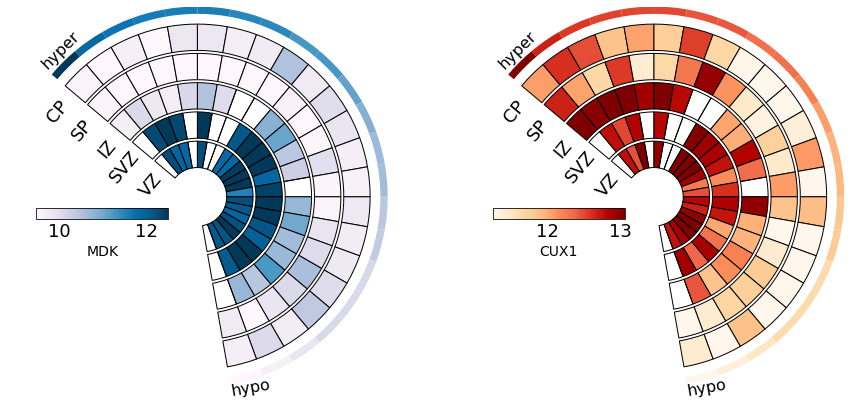

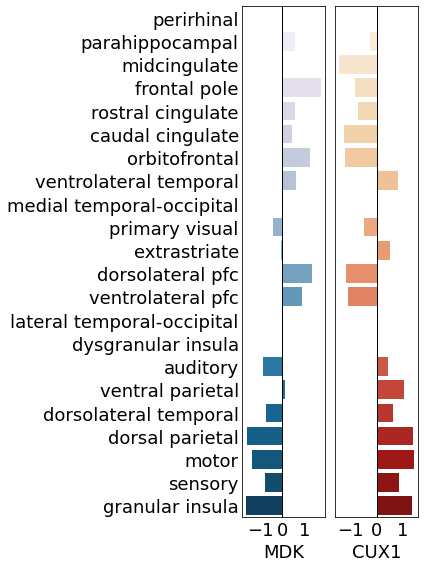

In [31]:
drop_zones_plus_perirhinal = ['entorhinal',
                              'hippocampus',
                              'paleocortex',
                              'retrosplenial']


fig, ax = plt.subplots(1,2, figsize=(15,8))
fig2, ax2 = plt.subplots(1,2, figsize=(6,8), sharey=True)

# negative
gene = 'MDK'
timepoint = 'mid'
# select data
plot_df = microarray_data[(microarray_data['gene'].isin([gene])) & (microarray_data['timepoint'].isin([timepoint]))].drop('DS', axis=1)
plot_df = plot_df[~plot_df['cortical_region'].isin(drop_zones)]
# pivot to tissue x region
plot_df = plot_df[['tissue', 'cortical_region', 'gene', 'expression']].pivot_table(index='tissue', columns='cortical_region')
# rearrange for plot
plot_df = plot_df.reindex(['4.ventricular', '3.subventricular', '2.intermediate', '1.subplate', '0.cortical_plate'])
# get position of each parcel for index
index = [scaling_dict[p[1]] for p in plot_df.columns]

# plot decreasing gene data
wedge_plot(ax[0], plot_df.values, np.array(index), 
           data_label='MDK', num_regions=22, num_zones=5, 
           color_palette='PuBu', start_degree=140, end_degree=-80, show_index=True)

# bar plot of nromalised expression
norm_plot_df = plot_df.apply(zscore, axis=1, nan_policy='omit')
sns.barplot(y=np.array([c[1] for c in plot_df.columns])[np.argsort(index)], 
            x=norm_plot_df.loc['2.intermediate'][np.argsort(index)], palette='PuBu',
            ax=ax2[0])

# positive
gene = 'CUX1'
timepoint = 'mid'
# select data
plot_df = microarray_data[(microarray_data['gene'].isin([gene])) & (microarray_data['timepoint'].isin([timepoint]))].drop('DS', axis=1)
plot_df = plot_df[~plot_df['cortical_region'].isin(drop_zones)]

# pivot to tissue x region
plot_df = plot_df[['tissue', 'cortical_region', 'gene', 'expression']].pivot_table(index='tissue', columns='cortical_region')
# rearrange for plot
plot_df = plot_df.reindex(['4.ventricular', '3.subventricular', '2.intermediate', '1.subplate', '0.cortical_plate'])
# get position of each parcel for index
index = [scaling_dict[p[1]] for p in plot_df.columns]

# plot decreasing gene data
wedge_plot(ax[1], plot_df.values, np.array(index), 
           data_label='CUX1', num_regions=22, num_zones=5, 
           color_palette='OrRd', start_degree=140, end_degree=-80, show_index=True)

# bar plot of nromalised expression
norm_plot_df = plot_df.apply(zscore, axis=1, nan_policy='omit')
sns.barplot(y=np.array([c[1].replace('_', ' ') for c in plot_df.columns])[np.argsort(index)], 
            x=norm_plot_df.loc['2.intermediate'][np.argsort(index)], palette='OrRd',
            ax=ax2[1])

# formatting
for a in ax:
    a.text(-5.4, 4.4,'hyper', fontsize=FNT-2, rotation=45)
    a.text(1.1, -6.8,'hypo', fontsize=FNT-2, rotation=10)
    
for a in ax2:
    a.tick_params('both', length=0, labelsize=FNT)
    a.axvline(0, lw=1, color='black')

ax2[0].set_xlabel('MDK', fontsize=FNT)
ax2[1].set_xlabel('CUX1', fontsize=FNT)

plt.tight_layout()


fig.savefig('{:}/scaling-genes-selected-expression-{:}-{:}.png'.format(results_dir, scaling_model, correlation_model), dpi=300, transparent=False, facecolor='white')
fig2.savefig('{:}/scaling-genes-selected-expression-IZ-{:}-{:}.png'.format(results_dir, scaling_model, correlation_model), dpi=300, transparent=False, facecolor='white')